# Classification

In this chapter, we wil be using the MNIST dataset, which is a set of 70.000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the 'hello world' of machine learning:


**Scikit-learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset from OpenML.org**

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame= False)

In [2]:
X, y = mnist.data, mnist.target

There are 70.000 images, and each image has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255(black).

Let's take a peek at one digit from the dataset.
All we need to do is grap an instance's feature vector, reshape it to a 28x28 array, and display it using Matplotlib's imshow() function. We use cmap = "binary" to get a grayscale color map where 0 is white and 255 is black.


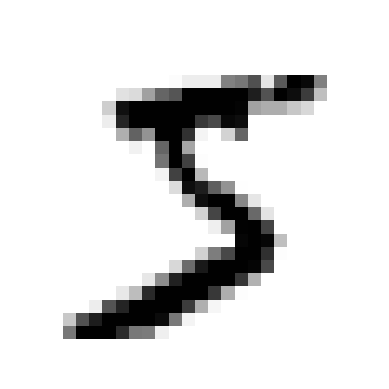

In [3]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

This looks like a 5, let's look what is the label ?

In [4]:
y[0]

'5'

But wait! You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset returned by fetch_openml() is actually already split into a training set (the first 60.000 images) and a test set (the last 10.000 images).



In [5]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

#### Training a Binary Classifier


Let's simplify the problem for now and only tro to identify one digit for example, the number 5. This '5-detector' will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5 First we'll create the target vectors for this classification task:

In [6]:
y_train_5 = (y_train == "5") # True for all 5s, false for all other digits
y_test_5 = (y_test == "5")


Now let's pick a classifier and train it. A good place to start is with a stochastic gradient descent (SGD, or sthoastic GD) classifier, using Scikit-Learn's SGDClassifier class. This classifier is capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time, which also make SGD well suited for online learning, as we we will see later, let's create an SGDClassifier and train it on the whole training set.

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now, we can use it to detect images of the number 5:

In [8]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 3 (False). Looks like it guessed wrong in this particular case ! Now let's evaluate this model's performance.

### MEASURING ACCURACY USING CROSS-VALIDATION


A good way to evaluate a model is to use cross-validation, just as you did in Chapter 2. Let's use the cross_val_score() function to evaluate our SGDClassifier model, using k-fold cross-validation with three folds. Remember that k-fold cross validation means splitting the training set into k folds (in this case, three), then traing the model k times, hlding out a different fold each time for evaluation




In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy", n_jobs=-1)
# n_jobs = -1 -> uses multiple threads to train.

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds ? <br>
This looks amazing, doesn't it? Well, before you get too excited, let's look at a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (non-5)

In [10]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints false : no 5s detected

False


Can you guess this model's accuracy ?

In [11]:
cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring="accuracy", n_jobs=-1)

array([0.90965, 0.90965, 0.90965])

That's right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).    A much better way to evaluate th eperformance of a classifies is to look at the confusion matric (CM)

## Confusion Matrices

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

Now we're ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred)

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in confusion matrix represents an actual class, while each column represents a predicted class. This first row of this matrix considers non-5 images (the negative class) 53.892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors).

The second row considers images of 5s (the positive class):
1.891 were wrongly classified as non-5s( false negatives also called type II errors), while the remaining 3530 were correctly classified as 5s (true positives)

A perfect classified would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right)


### Precision and Recall

In [14]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision score: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall score : {recall_score(y_train_5, y_train_pred)} ")


Precision score: 0.8370879772350012
Recall score : 0.6511713705958311 


Now our 5-detector does not look as shiny as it did when we looked at its accuracy. When it claims an image represents a 5, it is correctly only 83.7% of the time. Moreover, it only detects 65.31% of the 5s.


It is often convenient to combine precision and recall into a single metric called the F1 score, especially when you need a single metric to compare two classifiers. The f1 score is the Harmonic Mean of precision and recall. Whereas the regular mean treats all values euqally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

In [15]:
from sklearn.metrics import f1_score

print(f"F1 Score : {f1_score(y_train_5, y_train_pred)}")

F1 Score : 0.7325171197343847


## The Precision/Recall Trade-Off

The precision/recall trade-off images are ranked by their classifier score, and those above the chosen decision threshold are considered positie; the higher the threshold, the lower the recall, but (in general) the higher the precision.


In [16]:
#Instead of calling the classifier's predict() method, you can call its decision_function() method, which returns a score for each instance, you can then use any threshold you want to make predictions based on those scores.

y_scores = sgd_clf.decision_function([some_digit])
print(f"Y Scores : {y_scores}")
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

Y Scores : [2164.22030239]


array([False])

This confirms that raising the threshold decreases recall. The image actually represnets a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3.000

How do you decide which threshold to use? One option is to use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that yopu want to return decision scores instead of predictions.


In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function", n_jobs=-1)
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

With these scores, use the precision_recall_curve() function to computer precision and recall for all possible thresholds (the function add precision of 1 and a last recall of 0, corresponding to an infinite threshold)

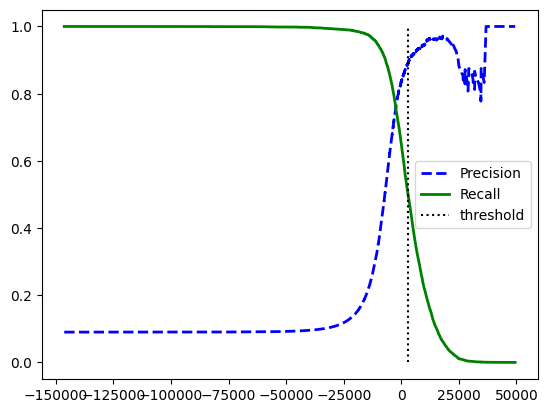

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label = "Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label = "threshold")
plt.legend()
[...]
plt.show()

You may wonder why precision curve is bumpier than the recall curve. The reason is that precision may sometimes go down when you raise the threshold (altough in general it will go up). <br>On the other hand, recall can only do down when the threshold is increased, which explains why its curve looks smooth.

At this threshold value, precision is near 90% and recall is around 50%. Another way to select a good precision/recall trade-off is to plot precision directly agaisnt recall, as shown in below.

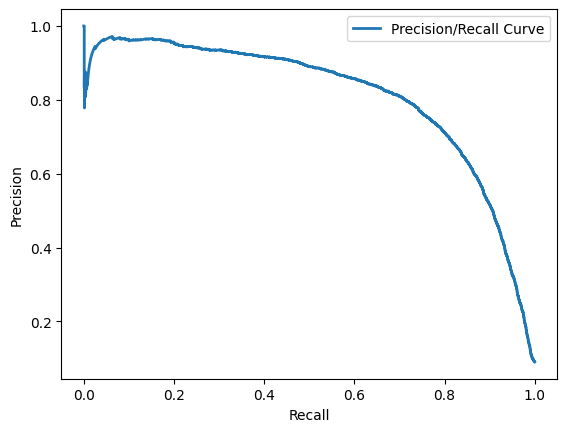

In [19]:
plt.plot(recalls, precisions, linewidth =2, label = "Precision/Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

You can see that precision really starts to fall sharply at around 80% recall. You will probably want to select a precision/recall trade-off just before that drop for example, at around 60% recall. But of course the choice depends on you project.<br>Suppose you decide to aim for 90% precision. You could use the first plot to find the threshold you need to use, but that's not very precise. Alternatively, you can search for the lowest threshold that gives you at least 90% precision. For this, you can use NumPy arrays' **argmax()** method. This returns the first index of the maximum value, which in this case means the first True value.

In [20]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.019499144183

To make predictions (on the trainig set for now), instyead of calling the classifier's predict() method, you can run this code

In [21]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [22]:
print(f"Precision score : {precision_score(y_train_5, y_train_pred_90)}")
print(f"Recall score : {recall_score(y_train_5, y_train_pred_90)}")

Precision score : 0.9000345901072293
Recall score : 0.4799852425751706


Great,we have 90% precision classifier! As you can see, it is farily easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you're done. But wait, not so fast: a high-precision classifier is not very useful if it is recall is too low! For many applications 48% recall wouldn't be great at all.

If someone says 'Let's reach 99% precision' you should ask 'At what recall.'


### The ROC Curve

The receiver opreating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR).

The FPR (also called the fall-out) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also specifity. Hence, the ROC curve plots sensitivity(recall) versus 1 - specifity.

To plot the ROC curve, you first use the roc_curve() function to compute the TPR and FPR for various threshold values:


In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


Then you can plot the FPR against the TPR using Matplotlib. To find the point that corresponds to 90% precision, we need to look for the index of the desired threshold. Since thresholds are listed in decreasing order in this case, we use <= instead of >= on the first line

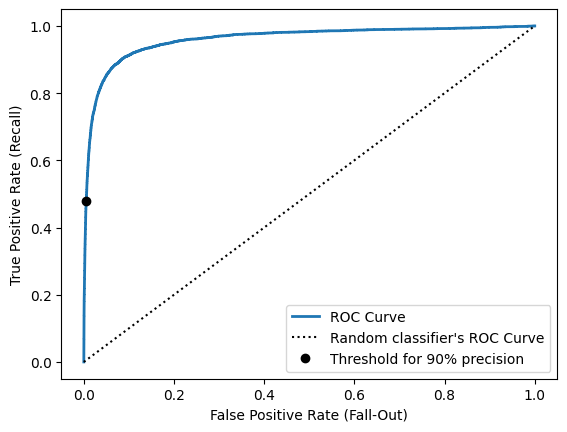

In [24]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth = 2, label = "ROC Curve")
plt.plot([0,1], [0,1], "k:", label = "Random classifier's ROC Curve")
plt.plot([fpr_90], [tpr_90], "ko", label = "Threshold for 90% precision")
plt.xlabel("False Positive Rate (Fall-Out)")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.show()


Once again there is a trade-off: the higher the recall TPR, the more False positive FPR the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far aya from that line as possible (toward the top-left corner),


One way to compare classifiers to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 
Scikit-learn provides a function to estimate the ROC AUC

In [25]:

from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### RandomForestClassifier

Let's now create a RandomForestClassifier, whose PR curve and F1 score we can compare to those of the SGDClassifier:.


The precision_recall_curve() function expects labels and scores for each instance, so we need to train the random forest clasifier and make it assign a score to each instance. But the RandomForestClassifier class does not have a decision_function() method, Luckily, it has a predict_proba() method that returns estimated class probabilities for each instance, and we can just use the probability of the positive class as a score, so precision_recall_curve() will work. We can call the cross_val_predict() function to train the RandomForestClassifier using cross-validation and make it predict class probabilities for every image as follows:


In [26]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba", n_jobs = -1)

In [27]:
y_probas_forest[:2]


array([[0.11, 0.89],
       [0.98, 0.02]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. Since each image is either positive or negative,  the estimated probabilities in each row add up to 100%

The second column contains the estimated probabilities for the positive class, so let's pas them to the precision_recall_curve() function:



In [28]:
y_score_forest = y_probas_forest[:, 1]
precision_forest, recalls_forest, threshold_forest = precision_recall_curve(y_train_5, y_score_forest)

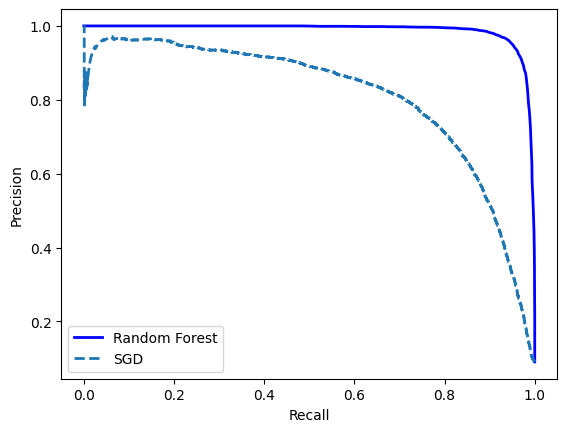

In [29]:
plt.plot(recalls_forest, precision_forest, "b-", linewidth = 2 , label = "Random Forest")
plt.plot(recalls, precisions, "--", linewidth = 2, label = "SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

Figure at the above, comparing PR curves: the random forest classifier is superior to the SGD classifier because its PR curve is much closer to the top-right corner, and it has a greater AUC

As you can see in figure, the RandomForestClassifier's PR curve looks much better than the SGDClassifier's: it comes much closer to the top right corner. It's F1 Score and ROC AUC score are also significantly better.



In [30]:
y_train_pred_forest = y_probas_forest[:, -1] >= 0.5 # positive proba >= 50%
print(f"F1 Score {f1_score(y_train_5, y_train_pred_forest)}")
print(f"ROC AUC Score {roc_auc_score(y_train_5, y_score_forest)}")
print(f"Precision Score : {precision_score(y_train_5, y_train_pred_forest)}")
print(f"Recall Score :  {recall_score(y_train_5, y_train_pred_forest)}")


F1 Score 0.9270445185330457
ROC AUC Score 0.9983296721818179
Precision Score : 0.9895331798199707
Recall Score :  0.8719793396052389


You know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use several metrics and curves to compare various models.

You're ready to try to deetct more than just 5s

## Multiclass Classification



In [31]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

That was easy! We trained the SVC using the original trget classes from 0 to 9 (y_train), instead of 5-versus-the-rest target classes (y_train_5). Since there are 10 classes (i.e. more than 2), Scikit-learn used to OvO strategy and trained 45 binary classifiers. Now let's make a prediction on an image.

In [32]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

That's correct! This code actually made 45 predictions one per pair of classes and it selected the class that won the most duels. If you call the decision_function() mehtod, you will see that it returns 10 scores per instance: oner per class. Each class gets a score equal to the number of won duels plus or minus a small tweak (max +- 0.33) to break ties, based on the classifier score


In [33]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The highest score is 9.3, and it's indeed the one corrsponding to class 5:

In [34]:
class_id = some_digit_scores.argmax()
class_id

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. in the case of MNIST, the index of each class in the classes_ array conveniently matches the class itself (e.g. the clas at index 5 happens to be class '5'), but in general you won't be so lucky; you will need to look up the class label like this.

In [35]:
svm_clf.classes_
#svm_clf.classes_[class_id] -> '5'

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes, Simply create an instance and pass a classifier to its contructor (it doesn't even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR stategy, based on an SVC:

In [36]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])


OneVsRestClassifier(estimator=SVC(random_state=42))

Let's make a prediction, and check the number of trained classifiers:

In [37]:
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10


Training an SGDClassifier on a multiclass dataset and using it to make predictions is just as easy

In [38]:
sgd_clf = SGDClassifier(random_state = 42, n_jobs = -1)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [39]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy", n_jobs= -1)


array([0.87365, 0.85835, 0.8689 ])

It get's over 85% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs increases accuracy above 89.91%


In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy", n_jobs=-1)

array([0.8983, 0.891 , 0.9018])

## Error Analysis

If this were a real project you would follow the steps in your machine learning project checklist. You'd explore data preparation options, try out multiple models, shortlist the best ones, fine-tune their hyperparameters using GridSearchCV or RandomizedSearchCV and automate as much as possible.

Here, we'll assume that you have found promising model and you want to find ways to improive it. one way to do this is to analyze the types of error it makes.

First, look at the confusion matrix. For this, you first need to make predictiong using the cross_val_predict() function; then you can pass the labels and predictions the confusion_matrix() functino, just like we did in earlier. 

However, since there are now 10 classes instead of 2, the confusion matric will contain quite a lot of numbers, and it may be hard to read.


A colored diagram of the confusion matrix is much easire to analyze. 

To plot such a diagram, use the ConfusionMatrixDisplay.from_predictions() function.

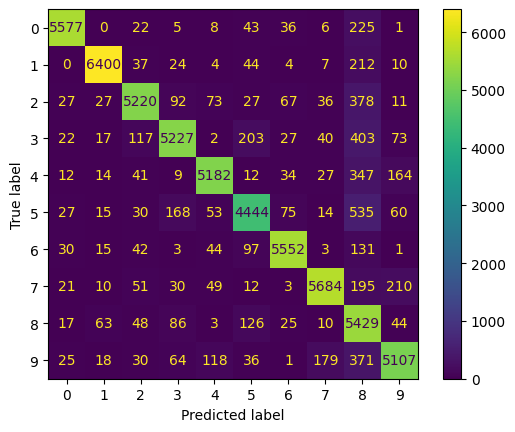

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3, n_jobs = -1)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

This produces the diagram. This function matrix looks preety good: most images are on the main diagonal which means that they were classified correcty. Notice that the cell on the diagnoal in row #5 and column #5 looks slightly darker than other digits. This could be because the model made more errors on 5s, or because there are fewer 5s in the dataset than the other digits. That's why it's important to normalize the function matrix.

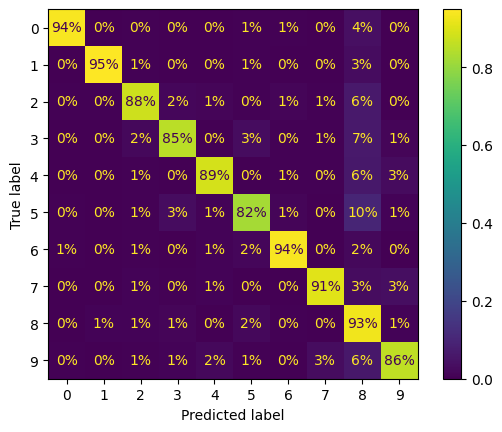

In [43]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize = "true" , values_format = ".0%")
plt.show()

Now we can easliy see that only 82%  of the images  of 5s were classified correctly. The most common error the model made with images of 5s was to misclassify them as 8s this happened for %10 of all 5s. But only 2% of 8s got misclassified as 5s; confusion matrices are generally not symmetrica.<br>If you look carefully, you will notice that many digits have been misclassified as 8s, but this is not immediately obvious from this diagram <br>If you want to make the errors stand out more, you can try putting zero weight on the correct predictions.

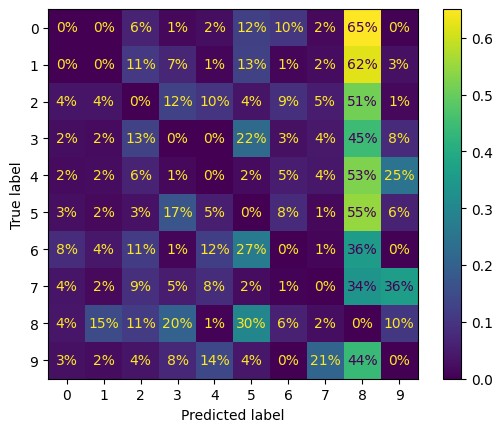

In [46]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize = "true", values_format=".0%")

## Multilabel Classification


Until now, each instance has always been assigned to just one class. But in some cases you may want your classifier to output multiple classes for each instance.

Consider a face-recognition classifier: what should it do if it recognizes several people in the same picture ?
It should attach one tag per person it recognies. Say the classifier has been trained to recognize three faces:

Alice, Bob, and Charlie. Then when the classifier is shown a picture of alcie and charlie. It should output [True, False, True] (meaning Alice 'yes', Bob 'No', Charlie 'Yes')

such a classification system that outputs multiple binary tags is called a **multilabel classification system**.


In [47]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

Indicates whether it is odd. Then the code creates a KNNeightborsClassifier instance, which supports multilabel classification (|not all classifiers do), and trains this model using the multiple targets array. Now you can make a predictions, and notice that it outputs two label.

In [52]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right, The digit 5 is indeed not large (False) and odd (True)

In [60]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3 , n_jobs=-1)
print(f"F1 Score: {f1_score(y_multilabel, y_train_knn_pred, average='macro')}")


F1 Score: 0.9764102655606048
